# User based collaborative filtering

### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy
import os

### Directory Structure

In [2]:
cwd = os.getcwd()
parent = os.path.dirname(cwd)
print(parent)

D:\MSU\CMSE 831 Project


In [3]:
movies_df = pd.read_csv(f'{parent}\data\movie.csv', usecols=['movieId', 'title'], dtype = {'movieId':'int32', 'title':'str'})
rating_df = pd.read_csv(fr'{parent}\data\rating.csv', usecols = ['userId', 'movieId', 'rating'],dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [4]:
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
rating_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [6]:
df = pd.merge(rating_df,movies_df,on='movieId')
df.head()

,userId,movieId,rating,title
0,1,2,3.5,Jumanji (1995)
1,5,2,3.0,Jumanji (1995)
2,13,2,3.0,Jumanji (1995)
3,29,2,3.0,Jumanji (1995)
4,34,2,3.0,Jumanji (1995)


Let's find a movie rating count

In [7]:
# Subset parameter defines in which columns to look for missing values.
combine_movie_rating = df.dropna(axis=0, subset=['title'])
movie_ratingCount = (combine_movie_rating.groupby(by=['title'])['rating'].count().reset_index().rename(columns={'rating':'totalRatingCount'}))[['title','totalRatingCount']]
movie_ratingCount.head()

,title,totalRatingCount
0,#chicagoGirl: The Social Network Takes on a Di...,3
1,$ (Dollars) (1971),24
2,$5 a Day (2008),39
3,$9.99 (2008),55
4,$ellebrity (Sellebrity) (2012),2


We will now merge this result to the 'combine_movie_rating' dataframe that we created

In [8]:
# We here do left join based on title column in combine_movie_rating (as left dataframe) and title column in movie_ratingCount (as right dataframe)
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount, left_on = 'title', right_on='title', how= 'left')
rating_with_totalRatingCount.head()

,userId,movieId,rating,title,totalRatingCount
0,1,2,3.5,Jumanji (1995),22243
1,5,2,3.0,Jumanji (1995),22243
2,13,2,3.0,Jumanji (1995),22243
3,29,2,3.0,Jumanji (1995),22243
4,34,2,3.0,Jumanji (1995),22243


Sampling the view for better representation

In [9]:
rating_with_totalRatingCount.sample(5)

,userId,movieId,rating,title,totalRatingCount
9279097,56816,8644,3.5,"I, Robot (2004)",9666
4531122,116900,2750,3.0,Radio Days (1987),2225
5669469,55481,648,4.5,Mission: Impossible (1996),37127
7422004,43787,153,3.0,Batman Forever (1995),32867
5688606,127265,648,3.0,Mission: Impossible (1996),37127


In [10]:
# Describing the totalRatingCount column statistically
pd.set_option('display.float_format', lambda x: '%.3f' %x)
print(movie_ratingCount['totalRatingCount'].describe())

count   26729.000
mean      748.261
std      3086.673
min         1.000
25%         3.000
50%        18.000
75%       205.000
max     67310.000
Name: totalRatingCount, dtype: float64


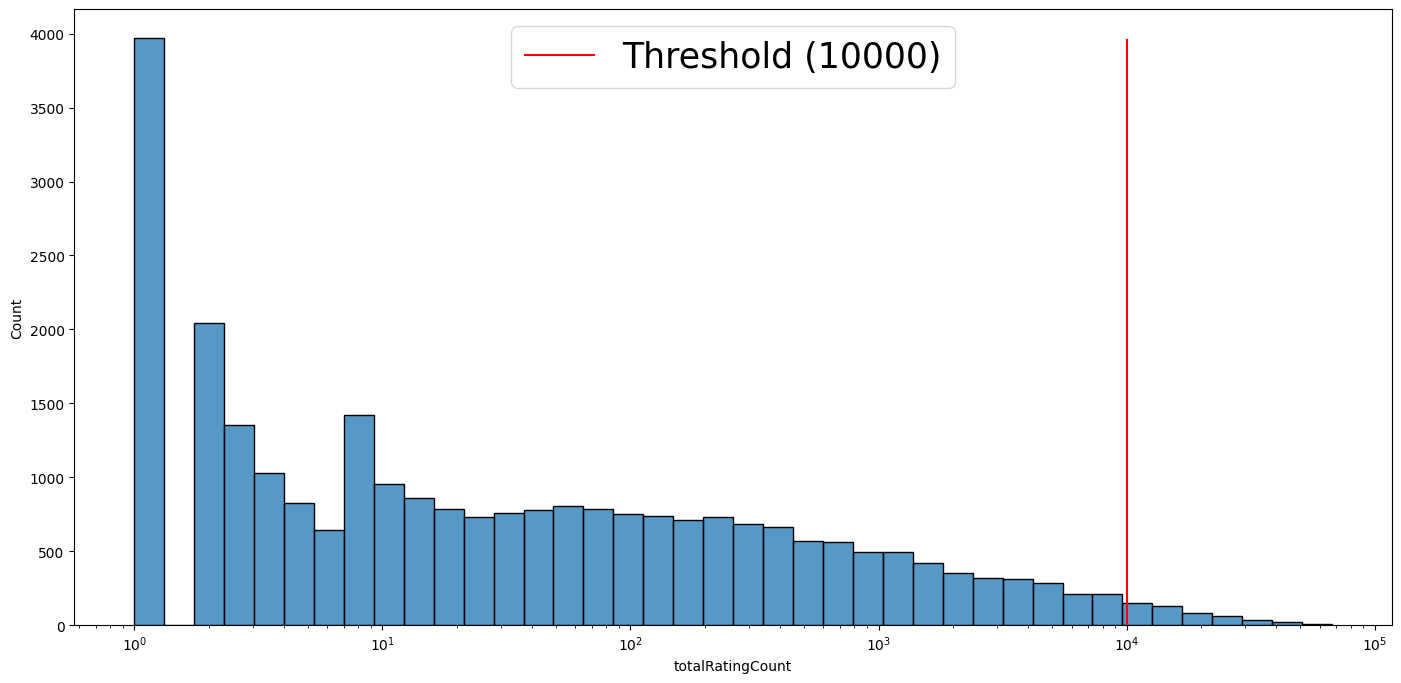

In [11]:
#movie_ratingCount.hist(column = 'totalRatingCount', bins =50, figsize=(20,5))
fig, ax = plt.subplots(figsize=(17,8))
plt.axvline(x=10000,ymax=0.95, c='red', label = 'Threshold (10000)');
sns.histplot(ax=ax, data = movie_ratingCount['totalRatingCount'], log_scale=True);
plt.legend(fontsize=25);

***Let's consider a popularity threshold rating for movie recommendations as 50***

In [12]:
popularity_threshold = 10000
rating_popular_movie = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_movie.head()

,userId,movieId,rating,title,totalRatingCount
0,1,2,3.500,Jumanji (1995),22243
1,5,2,3.000,Jumanji (1995),22243
2,13,2,3.000,Jumanji (1995),22243
3,29,2,3.000,Jumanji (1995),22243
4,34,2,3.000,Jumanji (1995),22243


In [13]:
# Sampling the results of the query
rating_popular_movie.sample(5)

,userId,movieId,rating,title,totalRatingCount
7530269,36734,208,2.000,Waterworld (1995),27775
12053192,129858,1729,4.000,Jackie Brown (1997),11557
2012506,90184,3996,5.000,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",25090
5336885,67334,364,4.000,"Lion King, The (1994)",38991
3339175,13041,780,2.500,Independence Day (a.k.a. ID4) (1996),47048


In [14]:
# Dimensions of my data
rating_popular_movie.shape

(9050403, 5)

### Creating Pivot Table

In [15]:
movie_features_df=rating_popular_movie.pivot_table(index='title',columns='userId',values='rating').fillna(0)
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
12 Angry Men (1957),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,4.500,0.000,0.000,0.000,4.000
2001: A Space Odyssey (1968),3.500,5.000,5.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
28 Days Later (2002),3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000
300 (2007),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.500


In [16]:
from scipy.sparse import csr_matrix # To convert pivot table to array matrix
movie_features_df_matrix = csr_matrix(movie_features_df.values)

### Concept of Cosine Similarity

<img src="https://dataaspirant.com/wp-content/uploads/2015/04/cosine.png"> </img>

***For cos (0 deg), similarity is 1***

***For cos (90 deg), similarity is 0***

### Training Nearest Neighbors ML Model

In [17]:
# Remember this is not K - Nearest Neighbors classifier or regressor. It's NearestNeighbors
from sklearn.neighbors import NearestNeighbors
# Generally, we use KNN to find similar vectors based on euclidean distance, but here we use the distance metric as cosine score
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

[Sklearn distance metrics documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric)

In [18]:
movie_features_df.shape

(462, 137658)

In [19]:
# movie_features_df.shape[0] samples a vector
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)
# Getting euclidean distance based on cosine metric and indices of respective neighbors which are nearest
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1,-1), n_neighbors=6)

339


[Differences between .flatten() and .ravel()](https://www.geeksforgeeks.org/differences-flatten-ravel-numpy/)

### ***Results***

In [20]:
# .flatten() returns a copy of the array collapsed into one dimension (row major).
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Robin Hood: Men in Tights (1993):

1: Hot Shots! Part Deux (1993), with distance of 0.5313413143157959:
2: Naked Gun 33 1/3: The Final Insult (1994), with distance of 0.5552611351013184:
3: Home Alone (1990), with distance of 0.5901440382003784:
4: Mrs. Doubtfire (1993), with distance of 0.5982285737991333:
5: Last Action Hero (1993), with distance of 0.6034529805183411:
